<a href="https://colab.research.google.com/github/gustavogit4/An-lise-de-Desempenho-de-Alunos/blob/main/An%C3%A1lise_de_Desempenho_de_Alunos_para_Melhoria_Educacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ====================
# 1. Introdução
# ====================

# Análise de Desempenho de Alunos  
**Autor**: Gustavo de Paula Silva  
**Última Atualização**: 13/02/2025

## Contexto  
Este projeto visa apoiar a **personalização do ensino** no Bernoulli Educação, identificando:  
- Fatores que influenciam o desempenho em matemática, leitura e escrita.  
- Impacto de intervenções como cursos preparatórios.  
- Oportunidades para segmentação de alunos por nível de desempenho.  

**Dataset**: [Students Performance in Exams](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams) (Kaggle), contendo:  
- Notas de matemática, leitura e escrita.  
- Dados demográficos (gênero, nível educacional dos pais).  
- Participação em cursos preparatórios.

# ====================
# 2. Pré-processamento e Limpeza
# ====================

In [ ]:
# Instalando a biblioteca Plotly
!pip install plotly

In [ ]:
# Importação de bibliotecas para manipulação de dados
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Estatísticas e pré-processamento
from scipy import stats
from sklearn.preprocessing import LabelEncoder

# Modelagem preditiva e aprendizado de máquina
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans

In [ ]:
# Carregando os dados
df = pd.read_csv('StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [ ]:
# Verificando dados ausentes
print("Dados ausentes por coluna:")
print(df.isnull().sum())

Dados ausentes por coluna:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [ ]:
# Pré-processamento otimizado
education_order = {
    'some high school': 0,
    'high school': 1,
    'some college': 2,
    "associate's degree": 3,
    "bachelor's degree": 4,
    "master's degree": 5
}

# Feature engineering
df['verbal_score'] = (df['reading score'] + df['writing score']) / 2
df['parental_education_encoded'] = df['parental level of education'].map(education_order)
df['male_with_prep'] = (df['gender'] == 'male') & (df['test preparation course'] == 'completed')

# Novas definições
categorical_features = ['race/ethnicity']
numeric_features = ['verbal_score', 'parental_education_encoded']
binary_features = ['male_with_prep']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(min_frequency=0.05, handle_unknown='ignore', drop='first'), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

In [ ]:
# Criando variável de desempenho médio
df['media_geral'] = (df['math score'] + df['reading score'] + df['writing score']) / 3

# ====================
# 3. Análise Exploratória (EDA)
# ====================

## 3.1. Distribuição das Notas

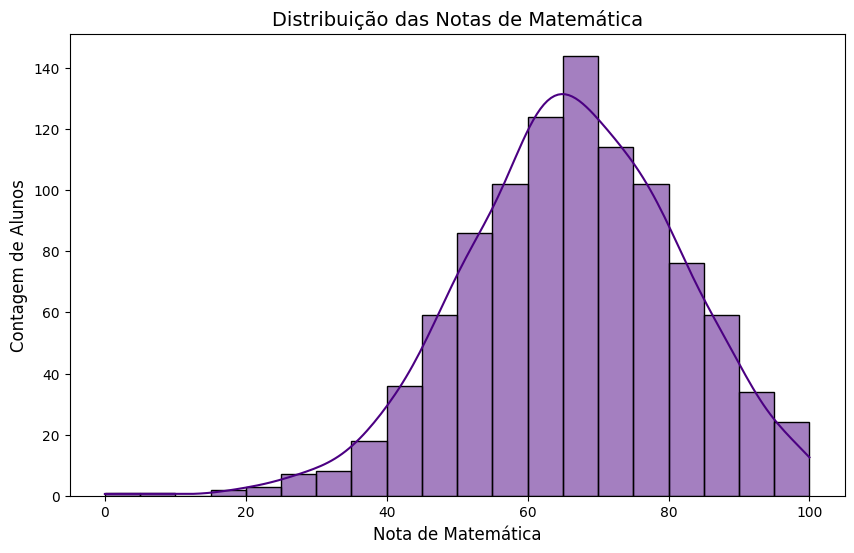

In [ ]:
# Histograma das notas de matemática
plt.figure(figsize=(10, 6))
sns.histplot(df['math score'], kde=True, color='#4B0082', bins=20)
plt.title('Distribuição das Notas de Matemática', fontsize=14)
plt.xlabel('Nota de Matemática', fontsize=12)
plt.ylabel('Contagem de Alunos', fontsize=12)
plt.show()

A maioria das notas está entre 50 e 80, com uma cauda longa à esquerda, indicando alunos com dificuldades.

## 3.2. Impacto do Curso Preparatório  

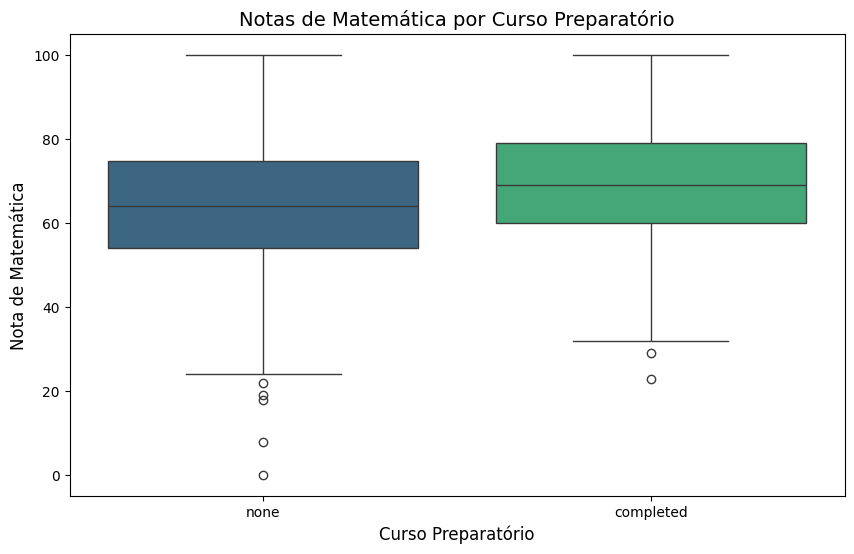

In [ ]:
# Boxplot comparativo
plt.figure(figsize=(10, 6))
sns.boxplot(data=df,x='test preparation course', y='math score', hue= 'test preparation course', palette='viridis')
plt.title('Notas de Matemática por Curso Preparatório', fontsize=14)
plt.xlabel('Curso Preparatório', fontsize=12)
plt.ylabel('Nota de Matemática', fontsize=12)
plt.legend([],[], frameon=False)
plt.show()

## 3.3. Correlação entre Disciplinas  

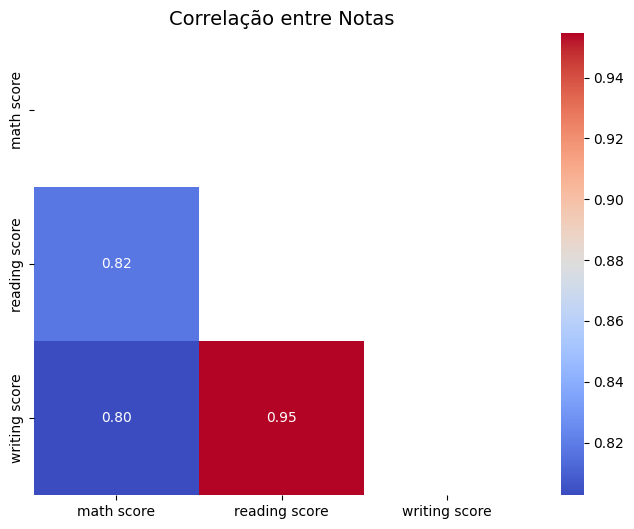

In [ ]:
# Matriz de correlação
corr = df[['math score', 'reading score', 'writing score']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(np.ones_like(corr)))
plt.title('Correlação entre Notas', fontsize=14)
plt.show()

Leitura e escrita têm alta correlação (r = 0.95), sugerindo habilidades complementares.

# ====================
# 4. Modelagem Preditiva
# ====================

In [ ]:
# Modelo de Predição Matemática
X = df.drop('math score', axis=1)
y = df['math score']

# Divisão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline com regressão linear
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Treinamento
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Métricas
y_pred = model.predict(X_test)
print(f"R²: {r2_score(y_test, y_pred):.2f}")

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"RMSE: {rmse:.2f}")

# Coeficientes
feature_names = numeric_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
coefficients = model.named_steps['regressor'].coef_

print("\nCoeficientes:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.2f}")

R²: 0.70
RMSE: 8.50

Coeficientes:
verbal_score: 12.03
parental_education_encoded: -0.37
race/ethnicity_group B: -0.97
race/ethnicity_group C: -1.52
race/ethnicity_group D: -0.05
race/ethnicity_group E: 4.08


Verbal Score: Cada ponto adicional na média das notas de leitura e escrita está associado a um aumento de aproximadamente 12 pontos na nota de matemática.

# ====================
# 5. TESTES ESTATÍSTICOS
# ====================


In [ ]:
# Teste t com cálculo do tamanho do efeito (Cohen's d)
def cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    pooled_std = np.sqrt((group1.std()**2 + group2.std()**2) / 2)
    return diff / pooled_std

grupo_prep = df[df['test preparation course'] == 'completed']['math score']
grupo_sem_prep = df[df['test preparation course'] == 'none']['math score']

t_stat, p_valor = stats.ttest_ind(grupo_prep, grupo_sem_prep)
d_cohen = cohen_d(grupo_prep, grupo_sem_prep)

print(f"\nTeste t para Curso Preparatório:")
print(f"Diferença média: {grupo_prep.mean() - grupo_sem_prep.mean():.1f} pontos")
print(f"p-valor: {p_valor:.4f}")
print(f"Tamanho do efeito (Cohen's d): {d_cohen:.2f}")


Teste t para Curso Preparatório:
Diferença média: 5.6 pontos
p-valor: 0.0000
Tamanho do efeito (Cohen's d): 0.38


Alunos que completaram o curso tiveram + 5.6 pontos em matemática (p < 0.001).

# ====================
# 6. CLUSTERIZAÇÃO
# ====================

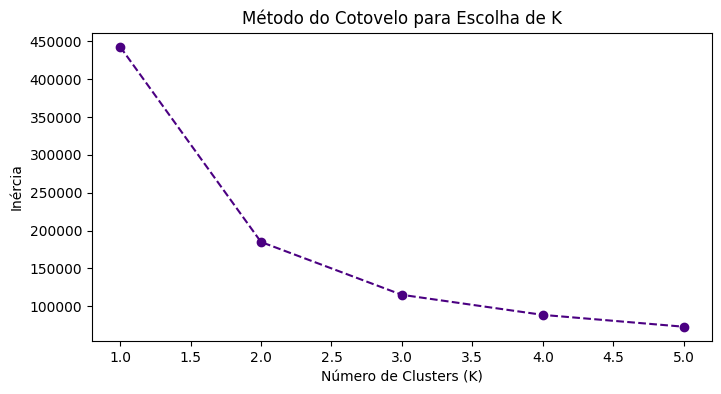

In [ ]:
# Método do Cotovelo para escolher K
X_cluster = df[['math score', 'reading score']]
inertia = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), inertia, marker='o', linestyle='--', color='#4B0082')
plt.title('Método do Cotovelo para Escolha de K')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.show()

In [ ]:
# Clusterização com K=3
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

In [ ]:
# Estatísticas por cluster
cluster_stats = df.groupby('cluster')[['math score', 'reading score']].mean()
print("\nEstatísticas por Cluster:")
print(cluster_stats)


Estatísticas por Cluster:
         math score  reading score
cluster                           
0         65.344519      68.407159
1         82.381107      84.850163
2         47.109756      50.983740


In [ ]:
# Gráfico interativo (Plotly)
fig = px.scatter(df, x='math score', y='reading score', color='cluster', title='Segmentação de Alunos por Desempenho',
labels={'math score': 'Nota de Matemática', 'reading score': 'Nota de Leitura'},
color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(legend_title_text='Cluster')
fig.show()

# ====================
# 7. CONCLUSÕES E RECOMENDAÇÕES
# ====================

## 7.1. Insights Estratégicos  
1. **Cursos Preparatórios como Alavanca**:  
   - Implementar um **sistema de incentivos** para aumentar a adesão aos cursos.  

2. **Integração de Disciplinas**:  
   - Criar **atividades interdisciplinares** (ex.: problemas de matemática baseados em textos).  

3. **Segmentação de Alunos**:  
   - **Cluster 1 (Alto Desempenho)**: Oferecer desafios avançados (ex.: olimpíadas).  
   - **Cluster 3 (Baixo Desempenho)**: Tutoria individualizada.  

## 7.2. Aplicação no Bernoulli  
- **Personalização no Sistema de Ensino**:  
  Integrar a segmentação por clusters à plataforma para recomendar conteúdos adaptativos.  
- **Alertas de Evasão**:  
  Usar modelos preditivos para identificar alunos em risco com antecedência.  

# ====================
# 8. Referências e Próximos Passos
# ====================

## 8.1. Limitações  
- Dados limitados a três disciplinas: Expandir análise para outras métricas (ex.: participação em aulas).  

## 8.2. Próximos Passos  
1. Coletar dados em tempo real via **plataforma Bernoulli** para atualizar modelos.  
2. Desenvolver um **dashboard de acompanhamento pedagógico** para gestores.  

**Repositório do Projeto**: [GitHub](https://github.com/gustavogit4/An-lise-de-Desempenho-de-Alunos)